In [1]:

import math

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from decimal import Decimal, getcontext
from glob import glob
from scipy import optimize
from scipy.interpolate import interp1d


## Functions

### Applying aperture correction and saturation correction

In [2]:

radius = 12     # radius of aperture in sub-pixels

# Encircled energy data (https://doi.org/10.3847/1538-3881/ab72a3)
radius_pixels = np.array([ 1.5, 2, 2.5, 3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50, 70, 80, 95 ])

fuv_energy_percentage = np.array([ 28.1, 40.7, 51.1, 59.1, 68.9, 74.6, 81.4, 85.0, 88.6, 91.3, 94.5, 96.9, 97.7, 98.3, 99.1, 99.5, 100.0 ])
fuv_ratio = fuv_energy_percentage / 100.
fuv_ratio_function = interp1d(radius_pixels, fuv_ratio, kind='cubic')



#---------------------------------------------------------------------------#



# Aperture correction
# -------------------

def apply_aperture_correction(CPF, CPF_err, radius): 
    CPF = CPF / fuv_ratio_function(radius)
    CPF_err = CPF_err / fuv_ratio_function(radius)
    return CPF, CPF_err



#---------------------------------------------------------------------------#



# Saturation correction
# ---------------------

def apply_saturation_correction(CPF, CPF_err):
    
    CPF_original = CPF
    CPF5_err_original = CPF_err
    
    CPF5 = CPF * 0.97     # 97% of the photons (observed counts per frame) that fall in the central 5x5 pixel sq. region
    CPF5_err = CPF_err * 0.97    
    
    if np.sum(CPF5 >= 0.6) != 0:
        print("\nCounts per frame exeeds 0.6; saturation correction cannot be applied")
        return

    ICPF5 = -1 * np.log(1 - CPF5)     # the corresponding actual counts per frame as per Poissonian statistics
    ICPF5_err = CPF5_err / CPF5

    ICORR = ICPF5 - CPF5     # ideal correction for saturation
    ICORR_err = np.sqrt((ICPF5_err ** 2) + (CPF5_err ** 2))

    RCORR = ICORR * (0.89 - (0.30 * (ICORR ** 2)))     # real or actual correction for saturation derived from empirical results
    RCORR_err = RCORR * np.sqrt((ICORR_err ** 2) + ((0.30 * 2 * ICORR * ICORR_err) ** 2))

    CCPF5 = CPF_original + RCORR
    CCPF5_err = np.sqrt((CPF5_err_original ** 2) + (RCORR_err ** 2))       
    return CCPF5, CCPF5_err



#---------------------------------------------------------------------------#



# Applying aperture and saturation corrections
# --------------------------------------------

def apply_all_correction(CPS, CPS_err, radius, framecount_per_sec):

    """
    aperture_correction = None # valid inputs are None / 'fuv' / 'nuv'.
    saturation_correction = False # True or False.
    """

    CPF = CPS / framecount_per_sec
    CPF_err = CPS_err / framecount_per_sec

    CPF, CPF_err = apply_aperture_correction(CPF, CPF_err, radius)
    CPF, CPF_err = apply_saturation_correction(CPF, CPF_err)
    
    CPS = CPF * framecount_per_sec
    CPS_err = CPF_err * framecount_per_sec
    return CPS, CPS_err


### Converting Mission Ellapsed Time (MET) to Modified Julian Date (MJD)

In [3]:

# Rearranging the date values
# ---------------------------

def rearrange_date(date_val):
    return date_val[-2:] + "/" + date_val[-4:-2] + "/" + date_val[0:4]



# Converting Mission Ellapsed Time (MET) to Modified Julian Date (MJD)
# --------------------------------------------------------------------

def met_to_mjd(met):
    jan2010 = 55197.0  # 2010.0(UTC) expressed with MJD format and scale UTC.
    mjd = (met / 86400.0) + jan2010  # 1 julian day = 86400 seconds.
    return mjd


### Least Squares Fit (Linear Regression)

In [4]:

# Best fit
def func_best_fit(x, m, c):
    y = m*x + c
    return y

# Best constant fit
def func_const(x, c):
    y = c
    return y


### Rounding off

In [5]:

def format_value_and_error(value, error):
    getcontext().rounding = 'ROUND_HALF_UP'
    
    # Convert inputs to Decimal to handle precision accurately
    d_value = Decimal(str(value))
    d_error = Decimal(str(error))
    
    if d_error <= Decimal('0'):
        raise ValueError("Error must be positive.")
    
    # Step 1: Round the error to one significant figure
    error_normalized = d_error.normalize()
    exponent = error_normalized.adjusted()  # Gets the exponent of the normalized form
    # Create a quantizer for one significant figure
    sig_fig_quant = Decimal('1e{}'.format(exponent))
    d_error_rounded = error_normalized.quantize(sig_fig_quant)
    
    # Step 2: Compute E_over_10 using the original error
    d_E_over_10 = d_error / Decimal('10')
    
    # Step 3: Determine the number of decimal places for the value
    if d_E_over_10 == Decimal('0'):
        decimal_places = 0
    else:
        # Convert to float for logarithm calculation
        E_over_10 = float(d_E_over_10)
        log = math.log10(1.0 / E_over_10)
        n = math.floor(log)
        decimal_places = int(n)
    
    # Step 4: Round the value to the determined decimal places
    if decimal_places >= 0:
        # For positive or zero decimal places, format as 0.000...
        quant = Decimal('1e-{}'.format(decimal_places))
    else:
        # For negative decimal places, round to the nearest 10, 100, etc.
        quant = Decimal('1e{}'.format(-decimal_places))
    d_rounded_value = d_value.quantize(quant)
    
    # Convert back to float for the output
    return (float(d_rounded_value), float(d_error_rounded))


# NGC188

### Field center coordinates of the image

In [6]:

"""
The (XC, YC) coordinates were noted down after manually looking at each image in SAODS9. The coordinates follow +1 indexing here.
"""

field_center_coordinates_NGC188 = pd.read_csv("NGC188/Data_info/NGC188_field_center_coordinates.csv")
field_center_coordinates_NGC188 = field_center_coordinates_NGC188.reset_index(drop=True)


### Background information of the image

In [7]:

bkg_img_file_NGC188 = "NGC188/source_detection/source_bkg_NGC188.txt"
data_txt_NGC188 = np.genfromtxt(bkg_img_file_NGC188, delimiter=',', dtype=None, encoding=None)
data_NGC188 = np.array([row.split() for row in data_txt_NGC188]).T

observation_id_NGC188 = data_NGC188[0]
bkg_NGC188 = data_NGC188[3]
bkg_data_NGC188 = pd.DataFrame(zip(observation_id_NGC188, bkg_NGC188), columns=['Observation ID', 'Median_background'])


### Applying corrections and storing the data

In [8]:

# Storing the data
# ----------------

obs_NGC188 = []              # Observation ID
exp_time_NGC188 = []         # Exposure time of the observation
obs_date_NGC188 = []         # Date of observation
mjd_time_NGC188 = []         # MJD
source_coord_NGC188 = []     # Source coordinates in image >> (multi-dim array : all candidates info)
source_coord_FF_NGC188 = []  # Source coordinates in flatfield F1 filter >> (multi-dim array : all candidates info)
FF_NGC188 = []               # FF values >> (multi-dim array : all candidates info)
med_bkg_NGC188 = []          # Median background of the image
bkg_sub_cps_NGC188 = []      # Background subtracted CPS >> (multi-dim array : all candidates info)
CPS_NGC188 = []              # Corrected CPS >> (multi-dim array : all candidates info)
CPS_err_NGC188 = []          # Corrected errors >> (multi-dim array : all candidates info)


#---------------------------------------------------------------------------------------------


for i in field_center_coordinates_NGC188['Observation ID']:
    
    obs_NGC188.append(i)
    obs_ID = i[:-7]
    obs_ID_episode = i[-6:]
    
    source_coord_I = pd.read_csv("NGC188/coord_cross_match/" + str(obs_ID) + "/" + i + "_I_coord_matches.csv")
    
    measured_cps = source_coord_I['source_cps'].to_numpy()
    measured_cps_err = source_coord_I['source_err_cps'].to_numpy()
    bkg_sub_cps_NGC188.append(measured_cps)
    
    x_center_source = source_coord_I['x_center_source'].to_numpy()
    y_center_source = source_coord_I['y_center_source'].to_numpy()
    
    coordinates_I = []
    for xi, yi in zip(x_center_source, y_center_source):
        coordinates_I.append([xi,yi])
    source_coord_NGC188.append(coordinates_I)
    
    
    
    # Extracting relevant image information
    # -------------------------------------
    
    I_img_file = glob("NGC188/Data_astrobrowse/" + obs_ID + "/" + obs_ID_episode + "*FIIP*F1I_l2img.fits.gz")
    hdu = fits.open(I_img_file[0])
    
    # AVGFRMT
    INT_TIME = hdu[0].header['INT_TIME']
    avg_frmrt = 1/INT_TIME
    
    # Exposure time
    exp_time = hdu[0].header['EXP_TIME']
    exp_time_NGC188.append(exp_time)
    
    hdu.close()
    
    
    
    # Retrieving flat-field image information
    # ---------------------------------------
    
    FF_data = pd.read_csv("NGC188/aperture_photometry/" + str(obs_ID) + "/" + str(obs_ID_episode) + "_FF_vals.csv")
    
    FF_vals = []
    coordinates_FF = []
    for x, y in zip(x_center_source, y_center_source):
        ff_candidates = FF_data.iloc[ (FF_data['xcenter']-x).abs().argsort()[:1] & (FF_data['ycenter']-y).abs().argsort()[:1] ]
        FF = ff_candidates['FF_vals'].item()
        xff = ff_candidates['x_flats'].item()
        yff = ff_candidates['y_flats'].item()
        FF_vals.append(FF)
        coordinates_FF.append([xff,yff])
    source_coord_FF_NGC188.append(coordinates_FF)
    FF_NGC188.append(FF_vals)
    
    FF_vals = np.array(FF_vals)
    
    
    CPS = measured_cps
    CPS_err = measured_cps_err
    
    
    
    # Removing flat-field information
    # -------------------------------
    
    CPS_noFF = CPS/FF_vals
    
    
    # Applying aperture and saturation corrections
    # --------------------------------------------
    
    CPS_corr_val, CPS_err_corr_val = apply_all_correction(CPS_noFF, CPS_err, radius, avg_frmrt)
    CPS_NGC188.append(CPS_corr_val)
    CPS_err_NGC188.append(CPS_err_corr_val)
    
    
    
    # Reintroducing flatfield corrections
    # -----------------------------------
    
    CPS_corrected = CPS_corr_val*FF_vals
    CPS_err_corrected = CPS_err_corr_val*FF_vals
    
    
    
    # Extracting relevant event list information
    # -------------------------------------------
    
    ce_file = glob("NGC188/Data_astrobrowse/" + obs_ID + "/" + obs_ID_episode + "*FIIP*F1_l2ce.fits.gz")
    hdu_list = fits.open(ce_file[0])
    
    # MJD
    event_data = Table(hdu_list[1].data)
    met = np.median(np.unique(event_data['MJD_L2']))     # mission ellapsed time in seconds
    mjd = met_to_mjd(met)
    mjd_time_NGC188.append(mjd)
    
    # UTC
    t = Time(mjd, format='mjd')
    t_utc = t.utc.datetime
    
    # Date of observation
    date_val = t_utc.strftime("%d/%m/%Y")
    obs_date_NGC188.append(date_val)
    
    hdu_list.close()
    
    
    
    # Median background
    # -----------------
    
    matched_obs_id = bkg_data_NGC188.loc[bkg_data_NGC188['Observation ID'] == i]
    median_bkg_val = matched_obs_id['Median_background'].tolist()
    med_bkg_NGC188.append(median_bkg_val[0])
    

### Master sheets for NGC188 candidates

In [9]:

# Converting candidate data to numpy arrays

source_coord_NGC188 = np.array(source_coord_NGC188)
source_coord_FF_NGC188 = np.array(source_coord_FF_NGC188)
FF_NGC188 = np.array(FF_NGC188)
bkg_sub_cps_NGC188 = np.array(bkg_sub_cps_NGC188)
CPS_NGC188 = np.array(CPS_NGC188)
CPS_err_NGC188 = np.array(CPS_err_NGC188)


med_bkg_NGC188 = np.array(med_bkg_NGC188, dtype=np.str_)
med_bkg_NGC188_float = np.array([f"{float(bkg):.3e}" for bkg in med_bkg_NGC188])


#### Candidate 1

In [10]:
candidate_1 = pd.DataFrame(zip(obs_NGC188, exp_time_NGC188, obs_date_NGC188, mjd_time_NGC188, np.round(source_coord_NGC188[:,0],1),
                               np.round(source_coord_FF_NGC188[:,0],1), FF_NGC188[:,0], med_bkg_NGC188_float, bkg_sub_cps_NGC188[:,0], 
                               CPS_NGC188[:,0], CPS_err_NGC188[:,0]), 
                           columns=['Observation ID', 'Exposure time', 'Date of observation', 'MJD', 'Source coordinates', 'FF coordinates', 
                                    'FF corrections', 'Median image background', 'Background subtracted CPS', 'Corrected CPS', 
                                    'Corrected CPS errors'])

candidate_1 = candidate_1.sort_values(by='MJD', ascending=True).reset_index(drop=True)
candidate_1.to_csv("master_sheets/candidate_1.csv", index=False)

candidate_1_formatted = candidate_1.round({'Exposure time':3, 'FF corrections':3, 'Median image background':3, 'Background subtracted CPS':3, 
                                           'Corrected CPS':3, 'Corrected CPS errors':3}).reset_index(drop=True)
candidate_1_formatted


,Observation ID,Exposure time,Date of observation,MJD,Source coordinates,FF coordinates,FF corrections,Median image background,Background subtracted CPS,Corrected CPS,Corrected CPS errors
0,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_06,561.901,22/03/2016,57469.570555,"[3146.3, 2294.7]","[344.8, 278.5]",0.998,3.698e-05,11.695,16.918,0.171
1,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_05,466.487,22/03/2016,57469.624789,"[2933.6, 2364.5]","[322.5, 257.1]",0.997,5.036e-05,12.086,17.676,0.192
2,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,1105.032,18/05/2016,57526.813515,"[2526.5, 2312.1]","[273.1, 234.8]",0.995,3.830e-05,11.775,17.132,0.123
3,LEVL2AS1UVT20160915G05_258T01_9000000666_uvt_08,621.101,15/09/2016,57646.251297,"[2065.2, 1828.4]","[259.8, 224.5]",0.997,3.967e-05,11.938,17.391,0.165
4,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,1194.736,30/01/2017,57783.493738,"[2378.4, 2622.3]","[277.5, 229.2]",0.994,3.160e-05,11.835,17.281,0.118
5,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_04,306.510,16/04/2017,57859.093016,"[2628.6, 2019.6]","[280.1, 228.3]",0.994,4.857e-05,11.901,17.401,0.234
6,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_02,433.197,16/04/2017,57859.214414,"[2931.4, 2135.0]","[280.7, 228.4]",0.994,4.111e-05,11.904,17.405,0.197
7,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_01,351.780,16/04/2017,57859.283817,"[2940.6, 2027.6]","[283.3, 232.2]",0.993,4.496e-05,11.495,16.637,0.214
8,LEVL2AS1UVT20171221C03_015T01_9000001788_uvt_01,148.589,21/12/2017,58108.583729,"[2980.3, 2602.6]","[324.1, 276.8]",1.002,4.255e-05,11.784,16.984,0.333
9,LEVL2AS1UVT20180222T02_002T01_9000001914_uvt_02,1854.627,23/02/2018,58172.450870,"[2740.9, 2252.4]","[278.4, 231.6]",0.994,3.437e-05,11.872,17.349,0.095


#### Candidate 2

In [11]:

candidate_2 = pd.DataFrame(zip(obs_NGC188, exp_time_NGC188, obs_date_NGC188, mjd_time_NGC188, np.round(source_coord_NGC188[:,1],1),
                               np.round(source_coord_FF_NGC188[:,1],1), FF_NGC188[:,1], med_bkg_NGC188_float, bkg_sub_cps_NGC188[:,1], 
                               CPS_NGC188[:,1], CPS_err_NGC188[:,1]), 
                           columns=['Observation ID', 'Exposure time', 'Date of observation', 'MJD', 'Source coordinates', 'FF coordinates', 
                                    'FF corrections', 'Median image background', 'Background subtracted CPS', 'Corrected CPS', 
                                    'Corrected CPS errors'])

candidate_2 = candidate_2.sort_values(by='MJD', ascending=True).reset_index(drop=True)
candidate_2.to_csv("master_sheets/candidate_2.csv", index=False)

candidate_2_formatted = candidate_2.round({'Exposure time':3, 'FF corrections':3, 'Median image background':3, 'Background subtracted CPS':3, 
                                           'Corrected CPS':3, 'Corrected CPS errors':3}).reset_index(drop=True)
candidate_2_formatted


,Observation ID,Exposure time,Date of observation,MJD,Source coordinates,FF coordinates,FF corrections,Median image background,Background subtracted CPS,Corrected CPS,Corrected CPS errors
0,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_06,561.901,22/03/2016,57469.570555,"[3934.8, 2530.5]","[443.4, 307.9]",1.009,3.698e-05,8.406,11.044,0.140
1,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_05,466.487,22/03/2016,57469.624789,"[3725.5, 2587.9]","[421.5, 285.0]",0.998,5.036e-05,8.383,11.161,0.154
2,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,1105.032,18/05/2016,57526.813515,"[3172.8, 1803.1]","[353.8, 171.2]",0.999,3.830e-05,8.450,11.250,0.101
3,LEVL2AS1UVT20160915G05_258T01_9000000666_uvt_08,621.101,15/09/2016,57646.251297,"[1320.2, 1480.3]","[166.7, 181.0]",1.021,3.967e-05,8.518,11.072,0.133
4,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,1194.736,30/01/2017,57783.493738,"[2734.4, 3363.6]","[322.0, 321.8]",1.002,3.160e-05,8.587,11.437,0.098
5,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_04,306.510,16/04/2017,57859.093016,"[3446.4, 1929.7]","[382.3, 217.1]",0.989,4.857e-05,8.456,11.395,0.192
6,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_02,433.197,16/04/2017,57859.214414,"[3749.3, 2045.2]","[382.9, 217.2]",0.989,4.111e-05,8.398,11.305,0.161
7,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_01,351.780,16/04/2017,57859.283817,"[3758.5, 1938.0]","[385.5, 221.0]",0.988,4.496e-05,8.293,11.155,0.178
8,LEVL2AS1UVT20171221C03_015T01_9000001788_uvt_01,148.589,21/12/2017,58108.583729,"[2741.5, 3390.0]","[294.2, 375.3]",1.006,4.255e-05,8.301,10.929,0.271
9,LEVL2AS1UVT20180222T02_002T01_9000001914_uvt_02,1854.627,23/02/2018,58172.450870,"[3346.2, 2809.2]","[354.0, 301.2]",0.994,3.437e-05,8.346,11.149,0.077


#### Candidate 3

In [12]:

candidate_3 = pd.DataFrame(zip(obs_NGC188, exp_time_NGC188, obs_date_NGC188, mjd_time_NGC188, np.round(source_coord_NGC188[:,2],1),
                               np.round(source_coord_FF_NGC188[:,2],1), FF_NGC188[:,2], med_bkg_NGC188_float, bkg_sub_cps_NGC188[:,2], 
                               CPS_NGC188[:,2], CPS_err_NGC188[:,2]), 
                           columns=['Observation ID', 'Exposure time', 'Date of observation', 'MJD', 'Source coordinates', 'FF coordinates', 
                                    'FF corrections', 'Median image background', 'Background subtracted CPS', 'Corrected CPS', 
                                    'Corrected CPS errors'])

candidate_3 = candidate_3.sort_values(by='MJD', ascending=True).reset_index(drop=True)
candidate_3.to_csv("master_sheets/candidate_3.csv", index=False)

candidate_3_formatted = candidate_3.round({'Exposure time':3, 'FF corrections':3, 'Median image background':3, 'Background subtracted CPS':3, 
                                           'Corrected CPS':3, 'Corrected CPS errors':3}).reset_index(drop=True)
candidate_3_formatted


,Observation ID,Exposure time,Date of observation,MJD,Source coordinates,FF coordinates,FF corrections,Median image background,Background subtracted CPS,Corrected CPS,Corrected CPS errors
0,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_06,561.901,22/03/2016,57469.570555,"[3078.5, 3304.2]","[336.3, 404.7]",1.012,3.698e-05,0.765,0.864,0.042
1,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_05,466.487,22/03/2016,57469.624789,"[2882.2, 3374.5]","[316.1, 383.4]",1.005,5.036e-05,0.780,0.888,0.047
2,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,1105.032,18/05/2016,57526.813515,"[3312.9, 2948.1]","[371.4, 314.3]",0.989,3.830e-05,0.775,0.896,0.031
3,LEVL2AS1UVT20160915G05_258T01_9000000666_uvt_08,621.101,15/09/2016,57646.251297,"[2279.7, 839.1]","[286.6, 100.8]",1.048,3.967e-05,0.863,0.942,0.042
4,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,1194.736,30/01/2017,57783.493738,"[1586.5, 3251.1]","[178.5, 307.8]",1.030,3.160e-05,0.895,0.995,0.031
5,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_04,306.510,16/04/2017,57859.093016,"[2958.6, 2975.2]","[321.3, 347.8]",0.999,4.857e-05,0.786,0.899,0.059
6,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_02,433.197,16/04/2017,57859.214414,"[3261.5, 3090.8]","[322.0, 347.9]",0.999,4.111e-05,0.780,0.893,0.049
7,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_01,351.780,16/04/2017,57859.283817,"[3270.6, 2983.6]","[324.5, 351.7]",1.000,4.496e-05,0.732,0.837,0.053
8,LEVL2AS1UVT20171221C03_015T01_9000001788_uvt_01,148.589,21/12/2017,58108.583729,"[1971.5, 2530.6]","[197.9, 267.8]",1.023,4.255e-05,0.778,0.869,0.083
9,LEVL2AS1UVT20180222T02_002T01_9000001914_uvt_02,1854.627,23/02/2018,58172.450870,"[2238.0, 3129.7]","[215.5, 341.3]",1.016,3.437e-05,0.841,0.947,0.024


## Short-term sensitivity variation

Candidate  1
----------

MJD midpoint:  59009.96344135475
Global average CPS: 16.936804693654572  Error: 0.024485652782043975

Slope: -0.0003826823737265988  Error: 4.58134768043679e-05
Intercept at 59010.0 MJD: 16.983217213991303  Error: 0.0424947206151863
Line of constant fit (CPS): 16.905512217951117  Error: 0.06189253950796073
Weighted RMS deviation from the line of constant fit (CPS): 0.4631613568062932 ( 2.739706143387276 %)

Rounded off values
Slope: (-0.00038, 5e-05)
Intercept at 59010.0 MJD: (16.98, 0.04)
Global average CPS: (16.94, 0.02)
Line of constant fit (CPS): (16.91, 0.06)
---------------------------------------------------------------------------

Candidate  2
----------

MJD midpoint:  59009.96344135475
Global average CPS: 10.885315308087002  Error: 0.01992248877929297

Slope: -0.0002834023956712621  Error: 4.1068930730634884e-05
Intercept at 59010.0 MJD: 10.936720622115072  Error: 0.038097874234478225
Line of constant fit (CPS): 10.878796145172055  Error: 0.050305421

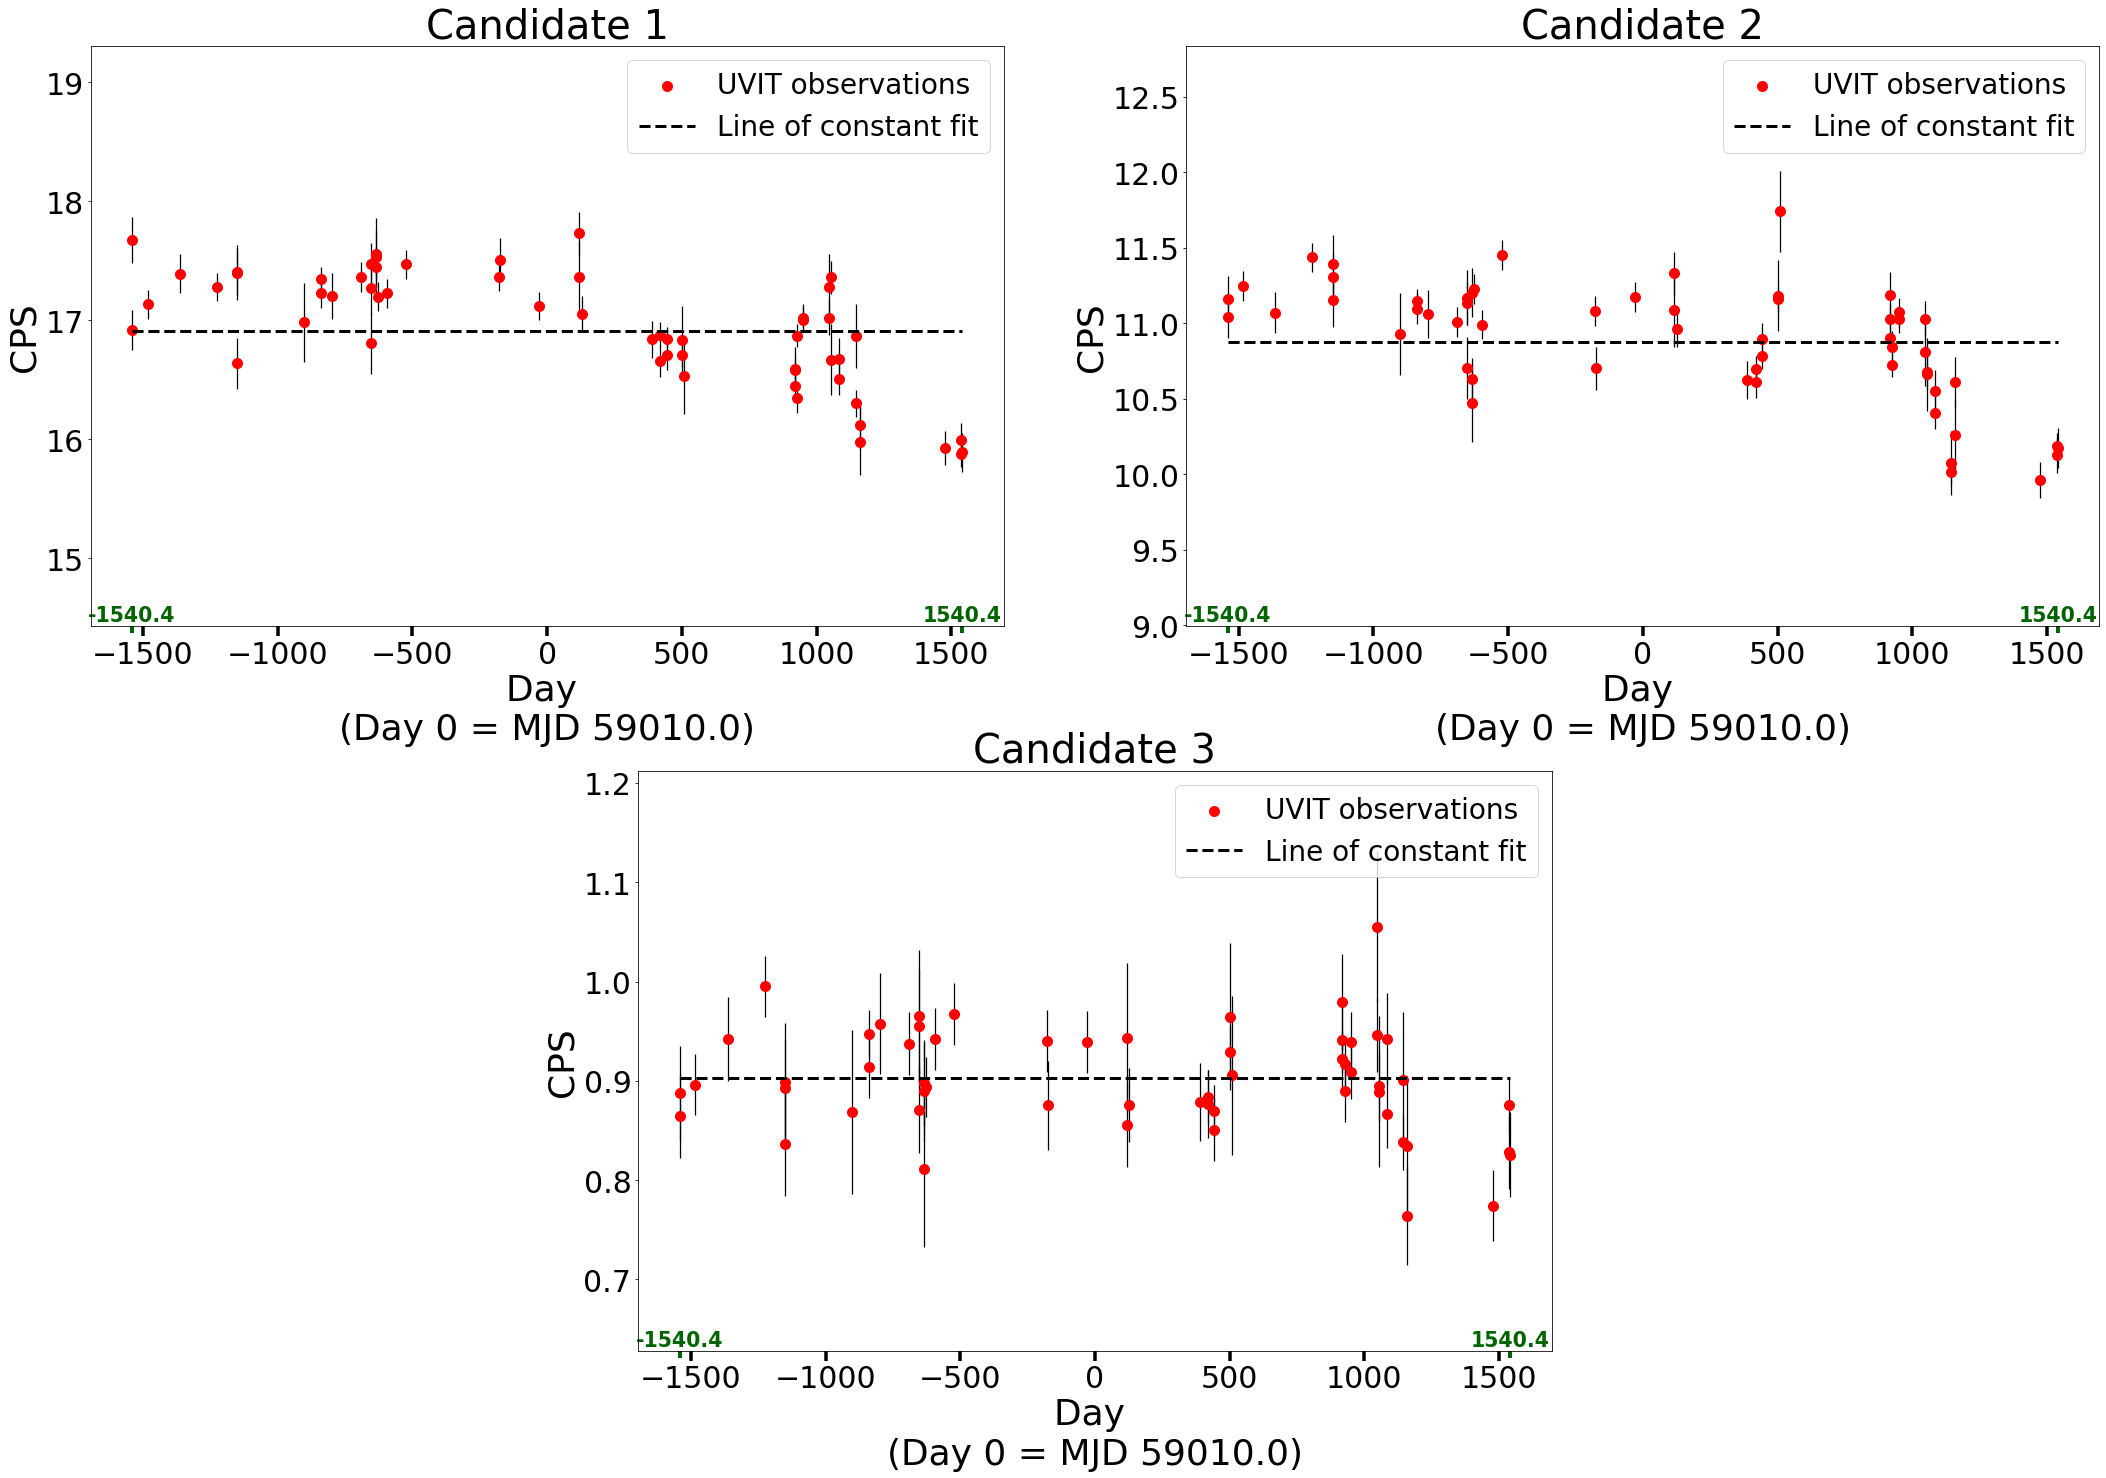

In [13]:

fig = plt.figure(figsize=(36,24))
gs = gridspec.GridSpec(2,4)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 1:3])
axs = [ax1, ax2, ax3]



for i, ax in zip([1,2,3], axs):
    
    candidate = eval("candidate_" + str(i))
    
    
    # MJD midpoint
    mjd_midpoint = (candidate['MJD'].iloc[-1] + candidate['MJD'].iloc[0]) / 2
    
    
    
    # Data
    # ----
    x = candidate['MJD'] - mjd_midpoint
    y = candidate['Corrected CPS']
    y_errors = candidate['Corrected CPS errors']
    
    
    
    # Global average
    # --------------
    
    # CPS
    global_avg = np.mean(y)
    
    # Errors (adding errors in quadrature)
    num_err = len(y_errors)
    sum_of_squares = sum(error ** 2 for error in y_errors)
    global_avg_err = math.sqrt(sum_of_squares)/num_err
    
    
    
    # Least squares
    # -------------
    
    
    # Best fit
    
    alpha, cov = optimize.curve_fit(func_best_fit, xdata=x, ydata=y, sigma=y_errors)
    
    m_fit = alpha[0]
    c_fit = alpha[1]
    d_m = np.sqrt(cov[0][0])
    d_c = np.sqrt(cov[1][1])
    
    y_predicted = m_fit*x + c_fit
    
    residuals = y - y_predicted
    chi_squared_fit = np.sum((residuals ** 2) / y_errors**2)
    
    
    
    # Constant fit
    
    alpha_const, cov_const = optimize.curve_fit(func_const, xdata=x, ydata=y, sigma=y_errors)
    c_fit_const = alpha_const[0]
    d_c_const = np.sqrt(cov_const[0][0])
    
    y_predicted_const = c_fit_const
    
    # Weighted RMS deviation from the line of constant fit
    weights = 1/(y_errors)**2
    resid_const_fit = y - y_predicted_const
    weighted_rmsd = np.sqrt( ( np.sum(weights*((resid_const_fit)**2)) ) / (np.sum(weights)) )
    
    
    print('Candidate ',i)
    print('----------')
    print("")
    print('MJD midpoint: ', mjd_midpoint)
    print('Global average CPS:', global_avg, ' Error:', global_avg_err)
    print("")
    print('Slope:', m_fit, ' Error:', d_m)
    print('Intercept at ' + str(np.round(mjd_midpoint, 1)) + ' MJD:', c_fit, ' Error:', d_c)
    print('Line of constant fit (CPS):', y_predicted_const, ' Error:', d_c_const)
    print('Weighted RMS deviation from the line of constant fit (CPS):', weighted_rmsd, '(', ((weighted_rmsd/y_predicted_const)*100), '%)')
    print("")
    print("Rounded off values")
    print('Slope:', format_value_and_error(m_fit, d_m))
    print('Intercept at ' + str(np.round(mjd_midpoint, 1)) + ' MJD:', format_value_and_error(c_fit, d_c))
    print('Global average CPS:', format_value_and_error(global_avg, global_avg_err))
    print('Line of constant fit (CPS):', format_value_and_error(y_predicted_const, d_c_const))
    print("---------------------------------------------------------------------------")
    print("")
    
    
    
    # Plotting
    # --------
    
    scale = 0.07
    
    scale_max = (np.max(y)*scale) + np.max(y) + np.max(y_errors)
    scale_min = np.min(y) - (np.min(y)*scale) - np.max(y_errors)
    
    ax.scatter(x, y, label='UVIT observations', color='red', marker='o', s=100, zorder=2)
    #x.plot(x, y_predicted, label='Line of best fit', color='black', linewidth=2.5, zorder=5)
    ax.hlines(y=y_predicted_const, xmin=x[0], xmax=x[len(candidate)-1], color='k', linewidth=3, linestyle = 'dashed', label='Line of constant fit', 
              zorder=3)
    ax.errorbar(x, y, yerr=y_errors, linestyle='', color='black', elinewidth=1.25, zorder=1)
    #x.hlines(y=global_avg, xmin=x[0], xmax=x[len(candidate)-1], label='Global average', linestyle='dashed', color='black', linewidth=2.5, zorder=4)
    
    ax.set_ylim([scale_min, scale_max])
    
    first_tick = np.round(x[0], 1)
    last_tick = np.round(x[len(candidate)-1], 1)
    minor_ticks = [first_tick, last_tick]
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(minor_ticks, minor=True, color='darkgreen', fontweight='bold')
    
    ax.tick_params(axis='x', which='major', direction='out', labelsize=30, length=10, width=3.5)
    ax.tick_params(axis='x', which='minor', direction='out', color='darkgreen', labelsize=20.5, length=7, width=4, pad=-28)
    ax.tick_params(axis='y', labelsize=30)
    
    ax.set_xlabel('Day \n(Day 0 = MJD ' + str(np.round(mjd_midpoint, 1)) + ')', fontsize=36)
    ax.set_ylabel('CPS', fontsize=36)
    
    ax.set_title('Candidate ' + str(i), size=40)
    ax.legend(fontsize=28)
    
plt.subplots_adjust(hspace=0.25, wspace=0.5)
plt.savefig("plots/senstivity_variation_NGC188", facecolor='white', bbox_inches='tight')
plt.show()
    

# HZ4

### Field center coordinates of the image

In [14]:

"""
The (XC, YC) coordinates were noted down after manually looking at each image in SAODS9. The coordinates follow +1 indexing here.
"""

field_center_coordinates_HZ4 = pd.read_csv("HZ4/Data_info/HZ4_field_center_coordinates.csv")
field_center_coordinates_HZ4 = field_center_coordinates_HZ4.reset_index(drop=True)


### Background information of the image

In [15]:

bkg_img_file_HZ4 = "HZ4/source_detection/source_bkg_HZ4.txt"
data_txt_HZ4 = np.genfromtxt(bkg_img_file_HZ4, delimiter=',', dtype=None, encoding=None)
data_HZ4 = np.array([row.split() for row in data_txt_HZ4]).T

observation_id_HZ4 = data_HZ4[0]
bkg_HZ4 = data_HZ4[3]
bkg_data_HZ4 = pd.DataFrame(zip(observation_id_HZ4, bkg_HZ4), columns=['Observation ID', 'Median background'])


### Applying corrections and storing the data

In [16]:

# Storing the data
# ----------------

obs_HZ4 = []              # Observation ID
exp_time_HZ4 = []         # Exposure time of the observation
obs_date_HZ4 = []         # Date of observation
mjd_time_HZ4 = []         # MJD
source_coord_HZ4 = []     # Source coordinates in image
source_coord_FF_HZ4 = []  # Source coordinates in flatfield F1 filter
FF_HZ4 = []               # FF values
med_bkg_HZ4 = []          # Median background of the image
bkg_sub_cps_HZ4 = []      # Background subtracted CPS
CPS_HZ4 = []              # Corrected CPS
CPS_err_HZ4 = []          # Corrected errors


#---------------------------------------------------------------------------------------------


HZ4_cps_file = pd.read_csv("HZ4/source_HZ4_cps.csv")


for i in field_center_coordinates_HZ4['Observation ID']:
    
    obs_HZ4.append(i)
    obs_ID = i[:-7]
    obs_ID_episode = i[-6:]
    
    source_coord_I = HZ4_cps_file.loc[HZ4_cps_file['Observation ID'] == obs_ID + '_' + obs_ID_episode]
    
    measured_cps = source_coord_I['source_cps'].item()
    measured_cps_err = source_coord_I['source_err_cps'].item()
    bkg_sub_cps_HZ4.append(measured_cps)
    
    x_center_source = source_coord_I['x_center_source'].item()
    y_center_source = source_coord_I['y_center_source'].item()
    coordinates_I = [x_center_source, y_center_source]
    source_coord_HZ4.append(coordinates_I)
    
    
    
    # Extracting relevant image information
    # -------------------------------------
    
    I_img_file = glob("HZ4/Data_astrobrowse/" + obs_ID + "/" + obs_ID_episode + "*FIIP*F1I_l2img.fits.gz")
    hdu = fits.open(I_img_file[0])
    
    # AVGFRMT
    INT_TIME = hdu[0].header['INT_TIME']
    avg_frmrt = 1/INT_TIME
    
    # Exposure time
    exp_time = hdu[0].header['EXP_TIME']
    exp_time_HZ4.append(exp_time)
    
    hdu.close()
    
    
    
    # Retrieving flat-field image information
    # -------------------------------
    
    FF_data = pd.read_csv("HZ4/aperture_photometry/" + str(obs_ID) + "/" + str(obs_ID_episode) + "_FF_vals.csv")
    ff_candidates = FF_data.iloc[ (FF_data['xcenter']-x_center_source).abs().argsort()[:1] & 
                                 (FF_data['ycenter']-y_center_source).abs().argsort()[:1] ]
    FF = ff_candidates['FF_vals'].item()
    xff = ff_candidates['x_flats'].item()
    yff = ff_candidates['y_flats'].item()
    
    coordinates_FF = [xff, yff]
    source_coord_FF_HZ4.append(coordinates_FF)
    FF_HZ4.append(FF)
    
    CPS = measured_cps
    CPS_err = measured_cps_err
    
    
    
    # Removing flat-field information
    # -------------------------------
    
    CPS_noFF = CPS/FF
    
    
    
    # Applying aperture and saturation corrections
    # --------------------------------------------
    
    CPS_corr_val, CPS_err_corr_val = apply_all_correction(CPS_noFF, CPS_err, radius, avg_frmrt)
    CPS_HZ4.append(CPS_corr_val)
    CPS_err_HZ4.append(CPS_err_corr_val)
    
    
    
    # Reintroducing flatfield corrections
    # -----------------------------------
    
    CPS_corrected = CPS_corr_val*FF
    CPS_err_corrected = CPS_err_corr_val*FF
    
    
    
    # Extracting relevant event list information
    # -------------------------------------------
    
    ce_file = glob("HZ4/Data_astrobrowse/" + obs_ID + "/" + obs_ID_episode + "*FIIP*F1_l2ce.fits.gz")
    hdu_list = fits.open(ce_file[0])
    
    # MJD
    event_data = Table(hdu_list[1].data)
    met = np.median(np.unique(event_data['MJD_L2']))     # mission ellapsed time in seconds
    mjd = met_to_mjd(met)
    mjd_time_HZ4.append(mjd)
    
    # UTC
    t = Time(mjd, format='mjd')
    t_utc = t.utc.datetime
    
    # Date of observation
    date_val = t_utc.strftime("%d/%m/%Y")
    obs_date_HZ4.append(date_val)
    
    hdu_list.close()
    
    
    
    # Median background
    # -----------------
    
    matched_obs_id = bkg_data_HZ4.loc[bkg_data_HZ4['Observation ID'] == i]
    median_bkg_val = matched_obs_id['Median background'].tolist()
    med_bkg_HZ4.append(median_bkg_val[0])
        

### Master sheets for HZ4

In [17]:

med_bkg_HZ4 = np.array(med_bkg_HZ4, dtype=np.str_)
med_bkg_HZ4_float = np.array([f"{float(bkg):.3e}" for bkg in med_bkg_HZ4])

HZ4 = pd.DataFrame(zip(obs_HZ4, exp_time_HZ4, obs_date_HZ4, mjd_time_HZ4, np.round(source_coord_HZ4,1), np.round(source_coord_FF_HZ4,1), FF_HZ4, 
                       med_bkg_HZ4_float, bkg_sub_cps_HZ4, CPS_HZ4, CPS_err_HZ4), 
                   columns=['Observation ID', 'Exposure time', 'Date of observation', 'MJD', 'Source coordinates', 'FF coordinates', 
                            'FF corrections', 'Median image background', 'Background subtracted CPS', 'Corrected CPS', 'Corrected CPS errors'])

HZ4 = HZ4.sort_values(by='MJD', ascending=True).reset_index(drop=True)
HZ4.to_csv("master_sheets/HZ4.csv", index=False)

HZ4_formatted = HZ4.round({'Exposure time':3, 'FF corrections':3, 'Median image background':3, 'Background subtracted CPS':3, 'Corrected CPS':3, 
                           'Corrected CPS errors':3}).reset_index(drop=True)
HZ4_formatted


,Observation ID,Exposure time,Date of observation,MJD,Source coordinates,FF coordinates,FF corrections,Median image background,Background subtracted CPS,Corrected CPS,Corrected CPS errors
0,AS1C02_002T01_9000000888_uvt_11,374.802,16/12/2016,57738.419638,"[2421.7, 2130.5]","[267.9, 210.1]",1.002,6.208e-05,19.613,23.385,0.259
1,AS1C02_002T01_9000000888_uvt_10,374.918,16/12/2016,57738.424038,"[2422.2, 2131.2]","[271.8, 213.3]",1.001,6.334e-05,19.882,23.756,0.261
2,AS1C02_002T01_9000000888_uvt_05,374.924,16/12/2016,57738.428432,"[2420.9, 2130.7]","[268.9, 216.2]",0.998,6.438e-05,20.305,24.361,0.264
3,AS1C03_013T01_9000001586_uvt_22,335.540,06/10/2017,58032.170751,"[2391.9, 2051.8]","[259.7, 218.2]",1.000,5.958e-05,19.750,23.606,0.275
4,AS1C03_013T01_9000001586_uvt_21,374.241,06/10/2017,58032.238622,"[2454.3, 2151.6]","[261.8, 222.5]",0.997,6.200e-05,19.900,23.874,0.261
5,AS1C03_013T01_9000001586_uvt_26,260.612,06/10/2017,58032.242386,"[2453.8, 2151.8]","[259.1, 223.2]",0.998,6.216e-05,19.920,23.873,0.313
6,AS1C03_013T01_9000001586_uvt_20,244.792,06/10/2017,58032.305527,"[2436.0, 2056.7]","[261.8, 216.1]",1.000,6.188e-05,19.629,23.448,0.321
7,AS1C04_010T01_9000003158_uvt_05,357.914,12/09/2019,58738.384319,"[2437.8, 2068.9]","[257.1, 214.5]",1.002,6.112e-05,19.982,23.847,0.267
8,AS1C04_010T01_9000003158_uvt_16,357.884,12/09/2019,58738.388746,"[2437.8, 2070.4]","[252.2, 212.7]",1.003,6.382e-05,19.266,22.915,0.262
9,AS1C04_010T01_9000003158_uvt_17,270.786,12/09/2019,58738.392595,"[2439.3, 2072.3]","[249.8, 209.7]",1.004,6.604e-05,19.721,23.481,0.305


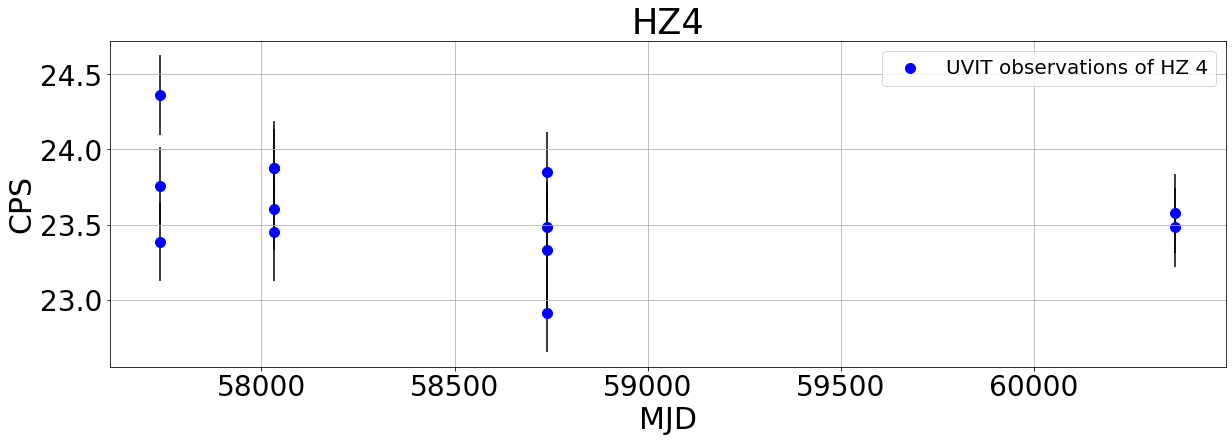

In [18]:

plt.figure(figsize=(20,6))

plt.scatter(HZ4['MJD'], HZ4['Corrected CPS'], label='UVIT observations of HZ 4', color='blue', marker='o', s=100, zorder=1)
plt.errorbar(HZ4['MJD'], HZ4['Corrected CPS'], yerr=HZ4['Corrected CPS errors'], color='black', elinewidth=1.5, linestyle='', zorder=0)

plt.xlabel('MJD', fontsize=30)
plt.ylabel('CPS', fontsize=30)

plt.tick_params(axis='x', labelsize=28)
plt.tick_params(axis='y', labelsize=28)

plt.legend(fontsize=20)
plt.title('HZ4', fontsize=35)

plt.grid()
plt.show()


### Mean values (MJD, CPS, CPS errors) for each HZ4 observation ID

In [19]:

HZ4_obs_series = HZ4['Observation ID'].str[:-7]
HZ4_obs_group = HZ4_obs_series.ne(HZ4_obs_series.shift()).cumsum()
HZ4_obs_ranges = HZ4_obs_series.groupby(HZ4_obs_group).apply(lambda x: (x.index[0], x.index[-1]))
HZ4_obs_data_range = [range(start, end+1) for start, end in HZ4_obs_ranges]
HZ4_obs_data_range


# Storing the data
# ----------------
uniq_obs_ID_HZ4 = []       # Unique HZ4 observation ID
MJD_HZ4_mean = []          # Mean MJD for the episodes falling under a unique HZ4 obs ID
CPS_HZ4_mean = []          # Mean CPS for the episodes falling under a unique HZ4 obs ID
CPS_err_HZ4_mean = []      # Mean CPS errors (calculated in quadrature) for the episodes falling under a unique HZ4 obs ID


for r in HZ4_obs_data_range:
    
    uniq_id = HZ4['Observation ID'][r].iloc[0][:-7]
    mean_mjd = np.mean(HZ4['MJD'][r])
    mean_CPS = np.mean(HZ4['Corrected CPS'][r])
    
    ### mean errors (adding in quadrature)
    error_points = HZ4['Corrected CPS errors'][r] 
    num_err = len(error_points) 
    sum_of_squares = sum(error ** 2 for error in error_points)
    mean_err = math.sqrt(sum_of_squares)/num_err
    
    MJD_HZ4_mean.append(mean_mjd)
    CPS_HZ4_mean.append(mean_CPS)
    CPS_err_HZ4_mean.append(mean_err)
    uniq_obs_ID_HZ4.append(uniq_id)


HZ4_mean = pd.DataFrame(zip(uniq_obs_ID_HZ4, MJD_HZ4_mean, CPS_HZ4_mean, CPS_err_HZ4_mean), 
                        columns=['Observation ID', 'Mean MJD', 'Mean CPS', 'Mean CPS errors'])
HZ4_mean

,Observation ID,Mean MJD,Mean CPS,Mean CPS errors
0,AS1C02_002T01_9000000888,57738.424036,23.834011,0.150723
1,AS1C03_013T01_9000001586,58032.239322,23.700325,0.146791
2,AS1C04_010T01_9000003158,58738.404111,23.393226,0.155208
3,AS1C02_002T01_9000006092,60364.551465,23.527601,0.187481


## Long-term sensitivity variation

HZ4
----------

MJD midpoint:  59051.48775081941
Global average CPS: 23.613790773626604  Error: 0.08042992701368465

Slope: -0.00011800268993900727  Error: 0.00010094893777963382
Intercept at 59051.5 MJD: 23.56749110149335  Error: 0.10611580698845663

Rounded off values
Slope: (-0.0001, 0.0001)
Intercept at 59051.5 MJD: (23.6, 0.1)
Global average CPS: (23.61, 0.08)



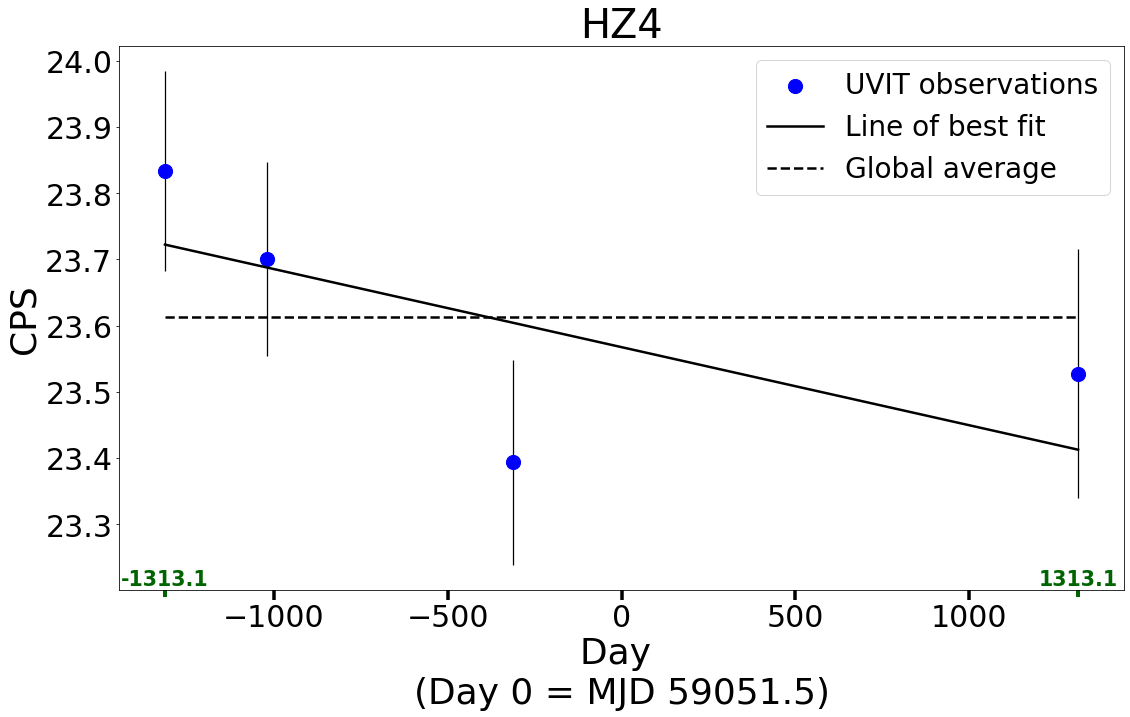

In [20]:

# MJD midpoint
mjd_midpoint_HZ4_mean = (HZ4_mean['Mean MJD'].iloc[-1] + HZ4_mean['Mean MJD'].iloc[0]) / 2



# Data
# ----
x_HZ4_mean = HZ4_mean['Mean MJD'] - mjd_midpoint_HZ4_mean
y_HZ4_mean = HZ4_mean['Mean CPS']
y_errors_HZ4_mean = HZ4_mean['Mean CPS errors']



# Global average
# --------------

# CPS
global_avg_HZ4_mean = np.mean(y_HZ4_mean)

# Errors (adding errors in quadrature)
num_err_HZ4 = len(y_errors_HZ4_mean)
sum_of_squares = sum(error ** 2 for error in y_errors_HZ4_mean)
global_avg_err_HZ4_mean = math.sqrt(sum_of_squares)/num_err_HZ4



# Least squares
# -------------


# Best fit

alpha_HZ4_mean, cov_HZ4_mean = optimize.curve_fit(func_best_fit, xdata=x_HZ4_mean, ydata=y_HZ4_mean, sigma=y_errors_HZ4_mean)

m_fit_HZ4_mean = alpha_HZ4_mean[0]
c_fit_HZ4_mean = alpha_HZ4_mean[1]
d_m_HZ4_mean = np.sqrt(cov_HZ4_mean[0][0])
d_c_HZ4_mean = np.sqrt(cov_HZ4_mean[1][1])

y_predicted_HZ4_mean = m_fit_HZ4_mean*x_HZ4_mean + c_fit_HZ4_mean

residuals_HZ4_mean = y_HZ4_mean - y_predicted_HZ4_mean
chi_squared_fit_HZ4_mean = np.sum((residuals_HZ4_mean ** 2) / y_errors_HZ4_mean**2)


# Constant fit

alpha_const_HZ4_mean, cov_const_HZ4_mean = optimize.curve_fit(func_const, xdata=x_HZ4_mean, ydata=y_HZ4_mean, sigma=y_errors_HZ4_mean)
c_fit_const_HZ4_mean = alpha_const_HZ4_mean[0]
d_c_const_HZ4_mean = np.sqrt(cov_const_HZ4_mean[0][0])
y_predicted_const_HZ4_mean = c_fit_const_HZ4_mean


print('HZ4')
print('----------')
print("")
print('MJD midpoint: ', mjd_midpoint_HZ4_mean)
print('Global average CPS:', global_avg_HZ4_mean, ' Error:', global_avg_err_HZ4_mean)
print("")
print('Slope:', m_fit_HZ4_mean, ' Error:', d_m_HZ4_mean)
print('Intercept at ' + str(np.round(mjd_midpoint_HZ4_mean, 1)) + ' MJD:', c_fit_HZ4_mean, ' Error:', d_c_HZ4_mean)
print("")
print("Rounded off values")
print('Slope:', format_value_and_error(m_fit_HZ4_mean, d_m_HZ4_mean))
print('Intercept at ' + str(np.round(mjd_midpoint_HZ4_mean, 1)) + ' MJD:', format_value_and_error(c_fit_HZ4_mean, d_c_HZ4_mean))
print('Global average CPS:', format_value_and_error(global_avg_HZ4_mean, global_avg_err_HZ4_mean))
print("")


# Plotting
# --------


fig, ax = plt.subplots(1,1, figsize=(18,10))

ax.scatter(x_HZ4_mean, y_HZ4_mean, label='UVIT observations', color='blue', marker='o', s=200, zorder=2)
ax.plot(x_HZ4_mean, y_predicted_HZ4_mean, label='Line of best fit', color='black', linewidth=2.5, zorder=3)
ax.errorbar(x_HZ4_mean, y_HZ4_mean, yerr=y_errors_HZ4_mean, color='black', linestyle='', elinewidth=1.25, zorder=1)
ax.hlines(y = global_avg_HZ4_mean, xmin=x_HZ4_mean[0], xmax=x_HZ4_mean[len(HZ4_mean)-1], label='Global average', color='black', linestyle='dashed', 
          linewidth=2.5, zorder=4)

first_tick = np.round(x_HZ4_mean[0], 1)
last_tick = np.round(x_HZ4_mean[len(HZ4_mean)-1], 1)
minor_ticks = [first_tick, last_tick]
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(minor_ticks, minor=True, color='darkgreen', fontweight='bold')

ax.tick_params(axis='x', which='major', direction='out', labelsize=30, length=10, width=3.5)
ax.tick_params(axis='x', which='minor', direction='out', color='darkgreen', labelsize=20.5, length=7, width=4, pad=-28)
ax.tick_params(axis='y', labelsize=30)

ax.set_xlabel('Day \n(Day 0 = MJD ' + str(np.round(mjd_midpoint_HZ4_mean, 1)) + ')', fontsize=36)
ax.set_ylabel('CPS', fontsize=36)

ax.set_title('HZ4', size=40)
ax.legend(fontsize=28)

plt.savefig("plots/senstivity_variation_HZ4", facecolor='white', bbox_inches='tight')
plt.show()
    

## Median background levels

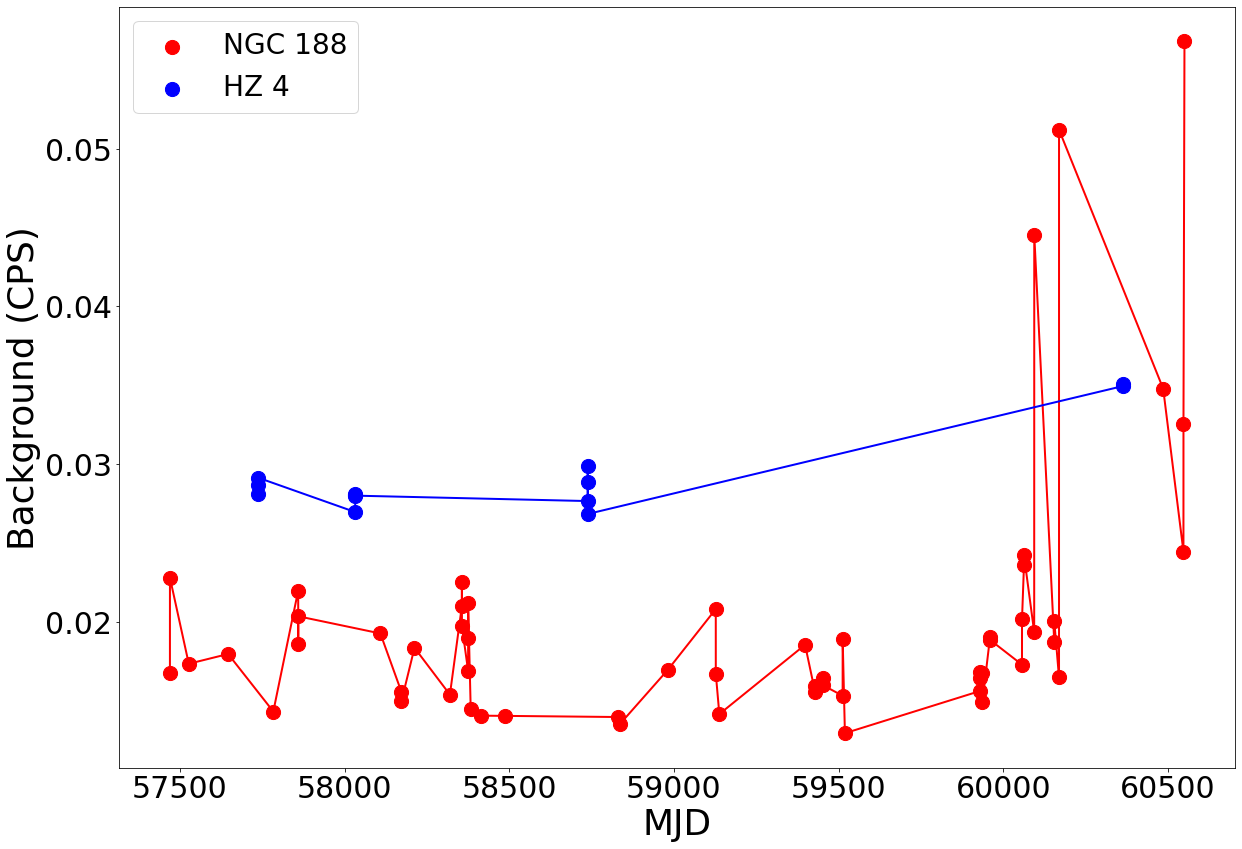

In [21]:

bkg_NGC188_col = np.array(pd.to_numeric(candidate_1['Median image background']))
bkg_HZ4_col = np.array(pd.to_numeric(HZ4['Median image background']))


# Background levels enclosed in a 12 sub-pixel aperture radius

bkg_NGC188_12px = bkg_NGC188_col * ( (np.pi)*((12)**2) )
bkg_HZ4_12px = bkg_HZ4_col * ( (np.pi)*((12)**2) )


# Plotting
# --------

fig, (ax) = plt.subplots(figsize=(20,14))

ax.scatter(candidate_1['MJD'], bkg_NGC188_12px, label='NGC 188', color='r', marker='o',  s=200)
ax.plot(candidate_1['MJD'], bkg_NGC188_12px, color='r', linewidth=2)

ax.scatter(HZ4['MJD'], bkg_HZ4_12px, label='HZ 4', color='b', marker='o', s=200)
ax.plot(HZ4['MJD'], bkg_HZ4_12px, color='b', linewidth=2)

ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

ax.set_xlabel('MJD', fontsize=36)
ax.set_ylabel('Background (CPS)', fontsize=36)

ax.legend(fontsize=28)

plt.savefig("plots/bkg_12px_NGC188_HZ4.png", facecolor='white', bbox_inches='tight')
plt.show()
